In [ ]:
#Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import os

In [2]:
# Device Configuration
#Selects GPU if available, otherwise selects CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
# DataLoader Class
class Load_Data:
    def __init__(self, data_dir, batch_size=32):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_loader, self.val_loader, self.test_loader, self.class_names = self._prepare_data()
    
    def _prepare_data(self):
        #Defines data augmentation for Training and Validation dataset
        transform = {
            'train': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val_test': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        
        #Load Datasets
        train_dataset = datasets.ImageFolder(os.path.join(self.data_dir, 'train'), transform=transform['train'])
        val_dataset = datasets.ImageFolder(os.path.join(self.data_dir, 'val'), transform=transform['val_test'])
        test_dataset = datasets.ImageFolder(os.path.join(self.data_dir, 'test'), transform=transform['val_test'])
        
        #Create Data Loaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        
        return train_loader, val_loader, test_loader, train_dataset.classes

In [ ]:
#Create Classifier class

class Classifier:
    def __init__(self, num_classes, lr=0.001, weight_decay=1e-4):
        #Load pretrained MobileNetv2 model
        self.model = models.mobilenet_v2(pretrained=True)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
        self.model.to(device)

        #Define loss function and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)

        #Define learning rate scheduler to reduce LR when validation loss plateaus 
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=3)
    
    def train(self, train_loader, val_loader, epochs=10):
        #Store training history
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
        
        #Train the model
        for epoch in range(epochs):
            train_loss, train_correct = 0, 0
            self.model.train()
            
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item() * images.size(0)
                train_correct += (outputs.argmax(1) == labels).sum().item()
            
            val_loss, val_acc = self.evaluate(val_loader)
            
            history['train_loss'].append(train_loss / len(train_loader.dataset))
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_correct / len(train_loader.dataset))
            history['val_acc'].append(val_acc)
            
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {history['train_loss'][-1]:.4f} | Train Acc: {history['train_acc'][-1]*100:.2f}% | Val Loss: {history['val_loss'][-1]:.4f} | Val Acc: {history['val_acc'][-1]*100:.2f}%")
        
        self.plot_training_history(history)
    
    def evaluate(self, val_loader):
        #Evaluate the model on Validation data
        self.model.eval()
        val_loss, correct_val = 0, 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                correct_val += (outputs.argmax(1) == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_acc = correct_val / len(val_loader.dataset)
        self.scheduler.step(val_loss)
        return val_loss, val_acc
    
    def plot_training_history(self, history):
        #Plot training and validation accuracy and loss
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss over Epochs')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Acc')
        plt.plot(history['val_acc'], label='Val Acc')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy over Epochs')
        plt.legend()
        plt.show()
    
    def test_and_plot_confusion_matrix(self, test_loader, class_names):
        self.model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                preds = outputs.argmax(1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())
        
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
        print(classification_report(all_labels, all_preds, target_names=class_names))



c:\Users\Aniruddha\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Aniruddha\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100 | Train Loss: 0.6990 | Train Acc: 74.47% | Val Loss: 0.4936 | Val Acc: 84.18%
Epoch 2/100 | Train Loss: 0.4700 | Train Acc: 82.96% | Val Loss: 0.5127 | Val Acc: 82.08%
Epoch 3/100 | Train Loss: 0.3715 | Train Acc: 87.19% | Val Loss: 0.3462 | Val Acc: 86.98%
Epoch 4/100 | Train Loss: 0.3801 | Train Acc: 87.11% | Val Loss: 0.3831 | Val Acc: 88.20%
Epoch 5/100 | Train Loss: 0.3111 | Train Acc: 88.81% | Val Loss: 0.3423 | Val Acc: 87.59%
Epoch 6/100 | Train Loss: 0.2809 | Train Acc: 89.73% | Val Loss: 0.2829 | Val Acc: 89.34%
Epoch 7/100 | Train Loss: 0.2734 | Train Acc: 90.67% | Val Loss: 0.3641 | Val Acc: 88.72%
Epoch 8/100 | Train Loss: 0.2827 | Train Acc: 90.12% | Val Loss: 0.2914 | Val Acc: 89.86%
Epoch 9/100 | Train Loss: 0.2168 | Train Acc: 92.67% | Val Loss: 0.2478 | Val Acc: 91.96%
Epoch 10/100 | Train Loss: 0.2020 | Train Acc: 93.02% | Val Loss: 0.3623 | Val Acc: 88.02%
Epoch 11/100 | Train Loss: 0.1947 | Train Acc: 92.91% | Val Loss: 0.4345 | Val Acc: 86.45%
Epoch 12

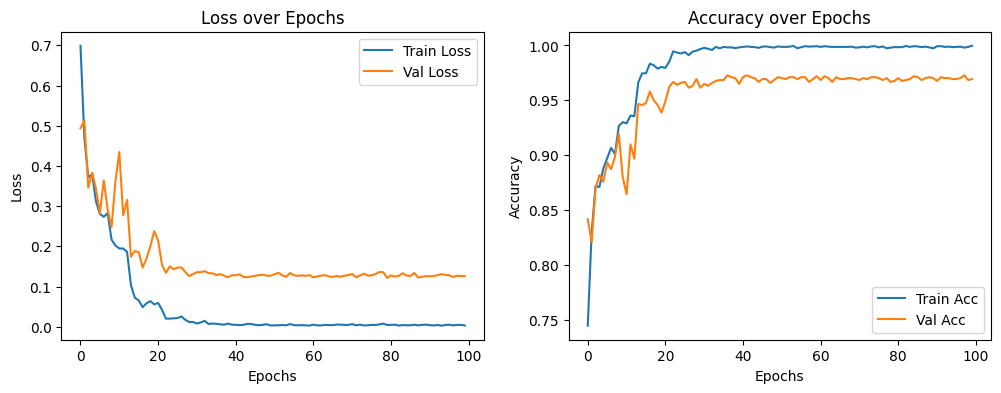

In [ ]:
# Execution
data = Load_Data(r'C:\Users\Aniruddha\Waste Classification\data', batch_size=32)
model = Classifier(num_classes=len(data.class_names))
model.train(data.train_loader, data.val_loader, epochs=100)

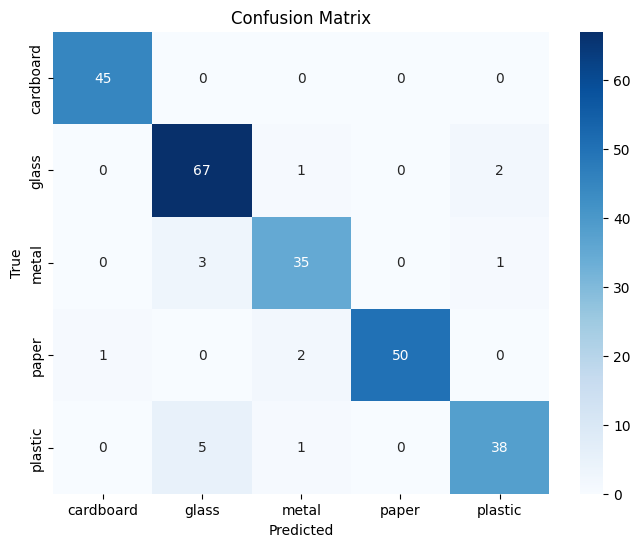

              precision    recall  f1-score   support

   cardboard       0.98      1.00      0.99        45
       glass       0.89      0.96      0.92        70
       metal       0.90      0.90      0.90        39
       paper       1.00      0.94      0.97        53
     plastic       0.93      0.86      0.89        44

    accuracy                           0.94       251
   macro avg       0.94      0.93      0.94       251
weighted avg       0.94      0.94      0.94       251



In [6]:
model.test_and_plot_confusion_matrix(data.test_loader, data.class_names)

In [47]:
torch.save(model.model.state_dict(), "model_weight.pth")